Loading data...

Training models...

Evaluating models...

Logistic Regression Performance:
Model        Logistic Regression
AUC                     0.605334
Precision               0.164569
Recall                  0.648654
F1                      0.262532
dtype: object
Skipping SHAP analysis for Logistic Regression as it's not an XGBoost model.

XGBoost Performance:
Model         XGBoost
AUC          0.616964
Precision    0.173937
Recall       0.635145
F1           0.273088
dtype: object


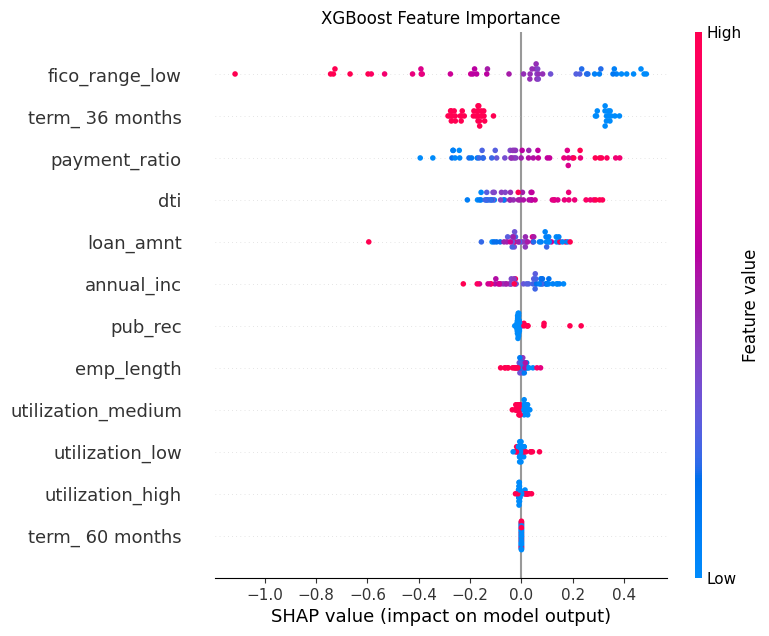


Pipeline completed successfully!


In [ ]:
!pip install pandas numpy scikit-learn xgboost shap mlflow --quiet
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer # Corrected import
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import shap
import mlflow
import joblib
import gc

# Ensure any previous MLflow run is ended
if mlflow.active_run():
    mlflow.end_run()

# Initialize MLflow
mlflow.set_experiment("Credit_Risk_Analysis")

# ======================
# ROBUST DATA LOADING
# ======================
def load_data(file_path='/content/accepted_2007_to_2018Q4.csv.gz', sample_frac=0.2):
    """Load data with proper dtype handling"""
    with mlflow.start_run(run_name="Data_Loading", nested=True):
        # Define dtype for known columns - Removed explicit dtypes
        # dtype = {
        #     'loan_amnt': 'float32',
        #     'annual_inc': 'float32',
        #     'dti': 'float32',
        #     'fico_range_low': 'float32',
        #     'pub_rec': 'float32',
        #     'revol_util': 'float32',
        #     'loan_status': 'object'
        # }

        # Columns to load (only those we'll use)
        usecols = [
            'loan_amnt', 'annual_inc', 'dti', 'fico_range_low',
            'term', 'emp_length', 'revol_util', 'pub_rec', 'loan_status'
        ]

        # Load in chunks with error handling
        chunks = []
        for chunk in pd.read_csv(file_path, chunksize=100000,
                               # dtype=dtype, # Removed dtype
                               usecols=usecols,
                               low_memory=False):
            chunks.append(chunk.sample(frac=sample_frac))

        df = pd.concat(chunks)

        # Clean and prepare target
        df = df.dropna(subset=['loan_status'])
        df['default'] = df['loan_status'].isin(['Charged Off', 'Default']).astype('int8')

        # Select final columns
        df = df[usecols[:-1] + ['default']].dropna()

        mlflow.log_param("sample_fraction", sample_frac)
        mlflow.log_metric("num_samples", len(df))

        return df

# ======================
# MEMORY-EFFICIENT FEATURE ENGINEERING
# ======================
def create_features(df):
    """Create features with dtype optimization"""
    with mlflow.start_run(run_name="Feature_Engineering", nested=True):
        # Payment ratio with safe division
        df['payment_ratio'] = np.divide(
            df['loan_amnt'],
            df['annual_inc'].replace(0, np.nan),
            out=np.zeros_like(df['loan_amnt']),
            where=df['annual_inc'].notna()
        ).astype('float32')

        # Utilization categories
        df['utilization'] = pd.cut(
            df['revol_util'].fillna(0),
            bins=[0, 30, 70, 100],
            labels=['low', 'medium', 'high'],
            ordered=False
        )

        # Clean employment length
        df['emp_length'] = (
            df['emp_length']
            .str.extract('(\d+)')[0]
            .fillna('0')
            .astype('float32')
        )

        # Downcast remaining columns
        # Added explicit downcasting after loading
        for col in ['pub_rec']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int8')
        for col in ['fico_range_low']:
             if col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('int16')
        for col in ['loan_amnt', 'annual_inc', 'dti', 'revol_util']:
             if col in df.columns:
                 df[col] = pd.to_numeric(df[col], errors='coerce').astype('float32')

        # Impute missing values before splitting
        numeric_features_for_imputation = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'payment_ratio', 'emp_length', 'pub_rec']
        categorical_features_for_imputation = ['term', 'utilization']

        for col in numeric_features_for_imputation:
            if col in df.columns:
                # Use median for numerical imputation
                df[col] = df[col].fillna(df[col].median())

        for col in categorical_features_for_imputation:
             if col in df.columns:
                 # Use most frequent for categorical imputation
                 df[col] = df[col].fillna(df[col].mode()[0])


        gc.collect()
        return df

# ======================
# MODEL TRAINING WITH MEMORY SAFETY
# ======================
def train_models(X_train, y_train):
    """Train models with memory management"""
    # Define preprocessing
    numeric_features = ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'payment_ratio', 'emp_length', 'pub_rec'] # Added pub_rec to numeric features
    categorical_features = ['term', 'utilization']

    # Add SimpleImputer to handle potential NaNs - Removed imputer here as imputation is done before splitting
    numeric_transformer = Pipeline(steps=[
        # ('imputer', SimpleImputer(strategy='median')), # Impute missing numerical values with median - Removed
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    models = {}

    # Logistic Regression
    with mlflow.start_run(run_name="Logistic_Regression", nested=True):
        lr_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=500, class_weight='balanced'))
        ])
        lr_model = GridSearchCV(lr_pipe, {'classifier__C': [0.1, 1]}, cv=3, scoring='roc_auc')
        lr_model.fit(X_train, y_train)

        mlflow.log_params({
            "model_type": "Logistic Regression",
            "best_C": lr_model.best_params_['classifier__C']
        })
        models['Logistic Regression'] = lr_model.best_estimator_
        del lr_model
        gc.collect()

    # XGBoost with reduced memory footprint
    with mlflow.start_run(run_name="XGBoost", nested=True):
        xgb_pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', XGBClassifier(
                tree_method='hist',  # More memory efficient
                enable_categorical=False,
                random_state=42, # Added random state for reproducibility
                scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum() # Added scale_pos_weight for imbalanced data
            ))
        ])
        xgb_model = GridSearchCV(xgb_pipe, {
            'classifier__max_depth': [3, 5, 7], # Expanded grid
            'classifier__learning_rate': [0.01, 0.1, 0.2], # Expanded grid
            'classifier__n_estimators': [100, 200, 300] # Expanded grid
        }, cv=3, scoring='roc_auc')
        xgb_model.fit(X_train, y_train)

        mlflow.log_params(xgb_model.best_params_)
        models['XGBoost'] = xgb_model.best_estimator_
        del xgb_model
        gc.collect()

    return models

# ======================
# LIGHTWEIGHT SHAP ANALYSIS
# ======================
def generate_shap_analysis(model, X_test, model_name, sample_size=100):
    """Generate SHAP explanations with subsampling"""
    # Check if the model is an XGBoost classifier by checking the type of the classifier step
    if not isinstance(model.named_steps['classifier'], XGBClassifier):
        print(f"Skipping SHAP analysis for {model_name} as it's not an XGBoost model.")
        return

    with mlflow.start_run(run_name=f"SHAP_{model_name}", nested=True):
        # Subsample for SHAP
        if len(X_test) > sample_size:
            X_sample = X_test.sample(sample_size, random_state=42)
        else:
            X_sample = X_test

        preprocessor = model.named_steps['preprocessor']

        # Get the classifier from the pipeline
        classifier = model.named_steps['classifier']
        explainer = shap.TreeExplainer(classifier)

        try:
            # Transform the sample data using the preprocessor
            X_sample_processed = preprocessor.transform(X_sample)

            # Ensure X_sample_processed is a dense numpy array for SHAP
            if hasattr(X_sample_processed, 'toarray'):
                X_sample_processed = X_sample_processed.toarray()

            # Get feature names after preprocessing
            feature_names = get_feature_names(model)

            # Get SHAP values
            shap_values = explainer.shap_values(X_sample_processed)

            # Summary plot
            plt.figure(figsize=(10,6))
            shap.summary_plot(shap_values, X_sample_processed,
                             feature_names=feature_names,
                             show=False)
            plt.title(f'{model_name} Feature Importance')
            mlflow.log_figure(plt.gcf(), f"shap_summary_{model_name}.png")
            plt.show()
            plt.close()

        except Exception as e:
            print(f"SHAP generation failed for {model_name}: {str(e)}")
            mlflow.log_param(f"shap_error_{model_name}", str(e))
        finally:
            del X_sample, X_sample_processed, shap_values
            gc.collect()

# ======================
# UTILITY FUNCTIONS
# ======================
def get_feature_names(model):
    """Get feature names after preprocessing"""
    preprocessor = model.named_steps['preprocessor']
    num_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][1].get_feature_names_out(
        preprocessor.transformers_[1][2])
    return list(num_features) + list(cat_features)

# ======================
# MAIN EXECUTION
# ======================
if __name__ == '__main__':
    try:
        # Ensure any previous MLflow run is ended before the main run starts
        if mlflow.active_run():
            mlflow.end_run()
        with mlflow.start_run(run_name="Main_Execution"):
            # Load and prepare data
            print("Loading data...")
            df = load_data(sample_frac=0.2)  # Start with 20% of data
            df = create_features(df)

            # Train-test split
            X_train, X_test, y_train, y_test = train_test_split(
                df.drop('default', axis=1),
                df['default'],
                test_size=0.2,
                random_state=42,
                stratify=df['default']
            )

            # Clean up memory
            del df
            gc.collect()

            # Train models
            print("\nTraining models...")
            models = train_models(X_train, y_train)

            # Evaluate
            print("\nEvaluating models...")
            results = []
            for name, model in models.items():
                y_pred = model.predict(X_test)
                metrics = {
                    'Model': name,
                    'AUC': roc_auc_score(y_test, y_pred),
                    'Precision': precision_score(y_test, y_pred),
                    'Recall': recall_score(y_test, y_pred),
                    'F1': f1_score(y_test, y_pred)
                }
                results.append(metrics)
                print(f"\n{name} Performance:")
                print(pd.Series(metrics))

                # Generate SHAP for XGBoost
                generate_shap_analysis(model, X_test, name, sample_size=50)

            # Save best model
            best_model = models['XGBoost']
            joblib.dump(best_model, 'best_model.pkl')
            mlflow.log_artifact('best_model.pkl')

            print("\nPipeline completed successfully!")

    except Exception as e:
        print(f"\nError: {str(e)}")
        # Log the error outside the main run context if possible,
        # or ensure it doesn't try to log to an already failed run.
        # A simple way is to just print and let the notebook error
        # indicate failure, or use a separate MLflow run for error logging.
        # For simplicity, we'll just print here.
        pass # Avoid logging to the failed run

    finally:
        gc.collect()
        # Ensure the main run is ended in case of success
        if mlflow.active_run():
             mlflow.end_run()